In [1]:
import sys
from pathlib import Path

project_root = Path.cwd().resolve().parent  # parent of notebooks/
sys.path.append(str(project_root))

from src.change_point_analysis import BrentOilChangePointAnalysis

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


In [2]:
brent_data_path = project_root / "data/raw/BrentOilPrices.csv"
change_point_analysis = BrentOilChangePointAnalysis(brent_data_path)

In [3]:
change_point_analysis.load_and_prepare_data()

2026-02-10 09:37:31,828 - INFO - Loading and preparing data.
2026-02-10 09:37:32,128 - INFO - Prepared 1802 daily log-return observations after thinning.


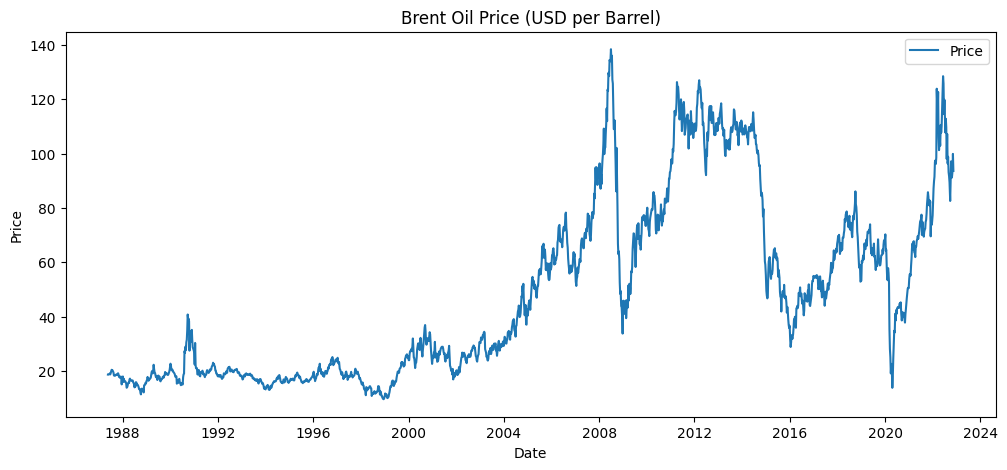

In [4]:
change_point_analysis.plot_price_series()

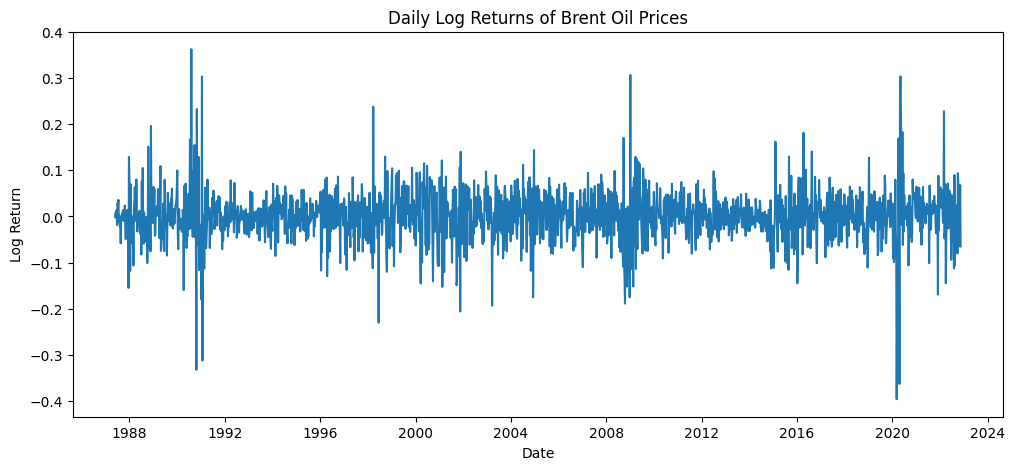

In [5]:
change_point_analysis.plot_log_returns()

In [6]:
change_point_analysis.build_and_run_model()

2026-02-10 09:37:32,435 - INFO - Building Bayesian change point model.
Multiprocess sampling (4 chains in 4 jobs)
2026-02-10 09:37:33,404 - INFO - Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
2026-02-10 09:37:33,404 - INFO - CompoundStep
>Metropolis: [tau]
2026-02-10 09:37:33,404 - INFO - >Metropolis: [tau]
>NUTS: [mu_1, mu_2, sigma]
2026-02-10 09:37:33,404 - INFO - >NUTS: [mu_1, mu_2, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3286 seconds.
2026-02-10 10:32:19,751 - INFO - Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3286 seconds.
2026-02-10 10:32:20,094 - INFO - Sampling completed.


          mean       sd   hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
tau    896.203  327.456  418.000  1434.000      14.59    3.983     512.0   
mu_1     0.001    0.002   -0.003     0.005       0.00    0.000    2466.0   
mu_2     0.001    0.002   -0.003     0.005       0.00    0.000    2239.0   
sigma    0.056    0.001    0.054     0.058       0.00    0.000    2621.0   

       ess_tail  r_hat  
tau       558.0    1.0  
mu_1     2097.0    1.0  
mu_2     2082.0    1.0  
sigma    2664.0    1.0  


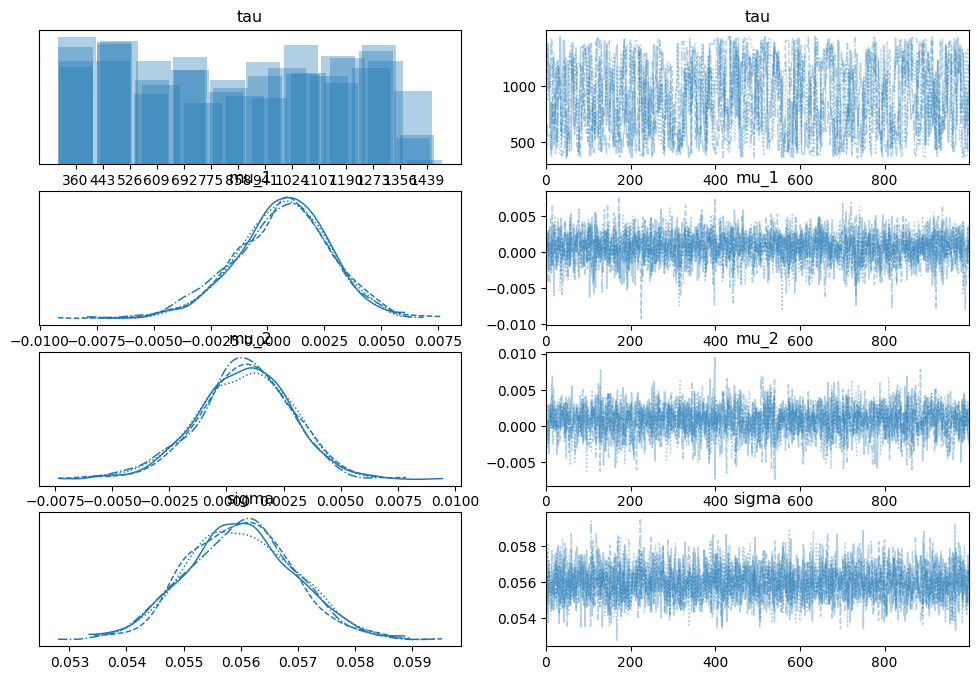

In [7]:
change_point_analysis.check_convergence()

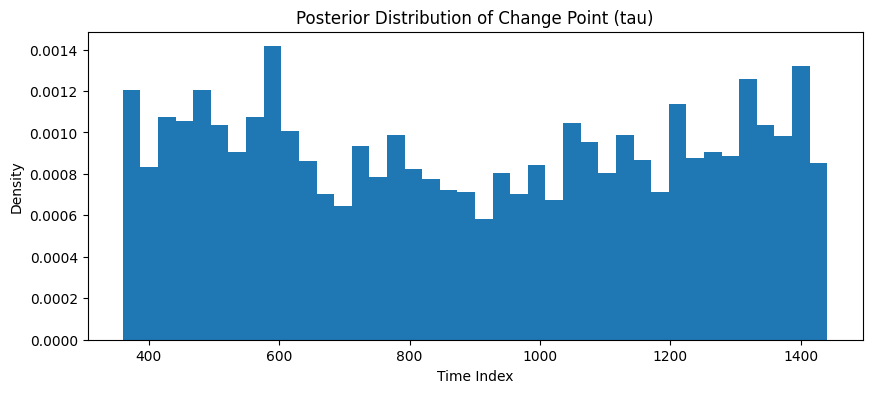

In [8]:
change_point_analysis.plot_tau_posterior()

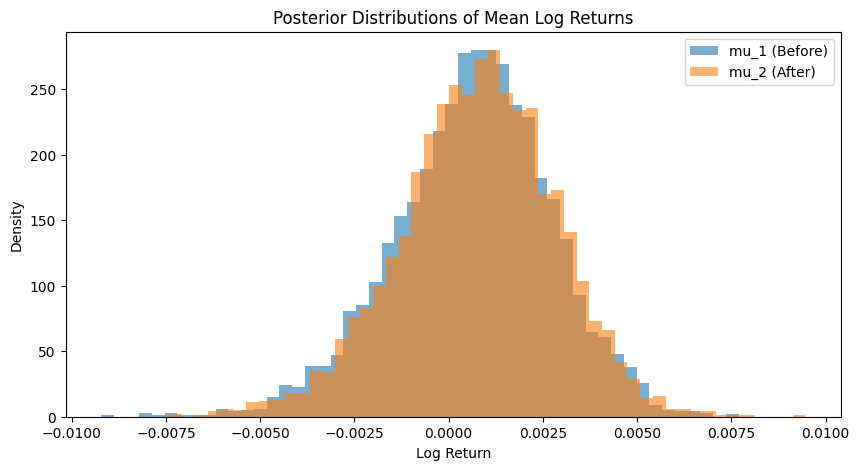

In [9]:
change_point_analysis.plot_mu_posteriors()

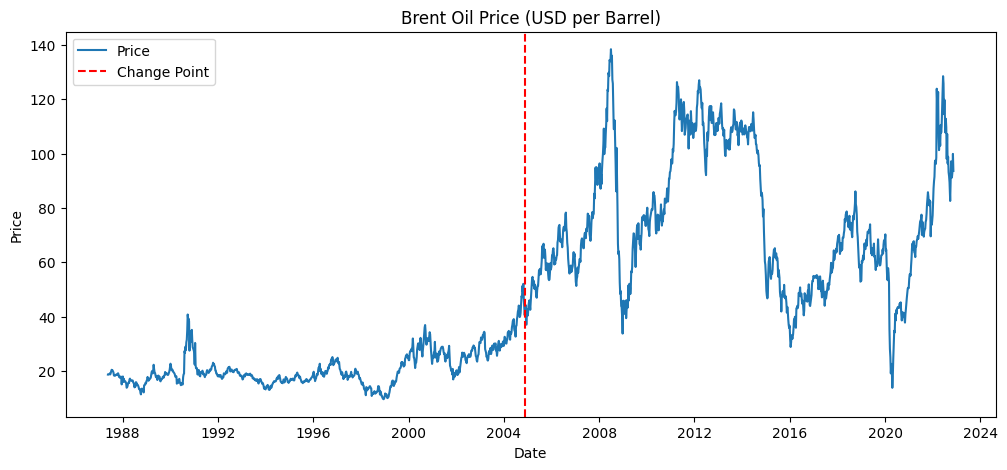

In [10]:
change_point_analysis.plot_price_series(overlay_tau=True)

In [11]:
tau_idx, date = change_point_analysis.get_change_point_date()
print( f"Detected change point around index {tau_idx}, date {date.date()}.")


Detected change point around index 889, date 2004-11-16.


In [12]:
impact = change_point_analysis.quantify_impact()

print(
            f"\nChange point detected around {date.date()}.\n"
            f"Mean daily log return shifted from "
            f"{impact['mean_log_return_before']:.5f} to "
            f"{impact['mean_log_return_after']:.5f}, "
            f"representing a {impact['percentage_change']:.2f}% change."
        )



Change point detected around 2004-11-16.
Mean daily log return shifted from 0.00065 to 0.00077, representing a 0.01% change.


In [15]:
event = change_point_analysis.associate_change_point_with_event()

if event is not None:
    print(
        f"Closest relevant event prior to change point:\n"
        f"{event['event_name']} on {event['event_date'].date()}: {event['description']}"
    )
else:
    print("No relevant event found near the change point.")


No relevant event found near the change point.


In [14]:
dashboard_data_dir = project_root / "data" / "processed" / "dashboard_data"
change_point_analysis.save_results_for_dashboard(
    price_path=dashboard_data_dir / "brent_prices.csv",
    change_point_path=dashboard_data_dir / "change_point_results.csv"
)


2026-02-10 10:32:21,356 - INFO - Historical prices saved to C:\Users\amare\Documents\KAIM\week-11\change-point-analysis\data\processed\dashboard_data\brent_prices.csv
2026-02-10 10:32:21,363 - INFO - Change point results saved to C:\Users\amare\Documents\KAIM\week-11\change-point-analysis\data\processed\dashboard_data\change_point_results.csv


# Task 2: Bayesian Change Point Analysis of Brent Oil Prices

## 1. Historical Price Overview

The chart of Brent Oil prices from the late 1980s through 2023 highlights long-term trends, structural shifts, and periods of extreme volatility. Prices were relatively stable for the first part of the period, fluctuating modestly, before a clear structural shift around 2005 marks the beginning of a sustained upward trend. After this point, prices experienced more dramatic swings, including a sharp spike leading up to the 2008 financial crisis, a period of high but relatively stable prices, and a sudden drop during the 2020 global pandemic. Following this drop, prices rebounded quickly, approaching previous highs before tapering slightly at the end of the series. The red dashed line on the chart represents the model’s detected change point, showing where the statistical analysis identifies a significant shift in market behavior.

**Insight:** This visualization illustrates that the detected change point aligns with the onset of heightened market volatility and rising prices. It signals a structural shift in oil market dynamics, suggesting that the market environment after this point differs from the earlier period in terms of both risk and return patterns.

---

## 2. Log Returns and Data Preparation

Because oil prices are non-stationary in levels, the analysis focuses on **daily log returns**, calculated as the natural logarithm of consecutive price ratios. This transformation stabilizes variance and makes the data suitable for modeling with a constant-variance Gaussian likelihood. Plotting the log returns reveals periods of clustered volatility and sudden shifts that are not easily observable in the raw price series.

**Insight:** The presence of volatility clustering and abrupt changes in the log returns justifies the use of a change point model rather than a single-regime model. These patterns indicate that market behavior is not constant over time, and capturing these shifts is critical for accurate modeling and insight generation.

---

## 3. Bayesian Change Point Model

The model identifies a **single structural break** in the log returns, representing the day when market behavior changed. Separate mean parameters are estimated for the periods before and after the change point, while a single volatility parameter is shared across both regimes. A deterministic switch function assigns each day’s return to either the "before" or "after" period based on the change point. Observed log returns are modeled with a normal likelihood whose mean is determined by this switch.

Posterior inference is performed using **Markov Chain Monte Carlo (MCMC)** sampling, producing full posterior distributions for the change point, average daily returns before and after, and volatility. This approach allows the model to capture uncertainty in both the timing and magnitude of the structural break, rather than producing a single fixed estimate.

**Insight:** By modeling the change point probabilistically, we can quantify not only the most likely timing of the shift but also the range of plausible daily returns. This provides a richer understanding of market behavior than a simple before-and-after comparison.

---

## 4. Model Diagnostics

Trace plots for the parameters show dense, well-mixed paths without systematic trends, indicating that the MCMC sampler explored the parameter space thoroughly. The posterior density plots for average daily returns before and after the shift and for volatility overlap across chains, confirming convergence. The trace for the change point explores possible dates across a broad range, reflecting its discrete nature.

**Insight:** These diagnostics provide confidence that the model has converged properly. The estimates for the change point and average daily returns are statistically reliable, meaning we can interpret the results with confidence that they reflect genuine structure in the data rather than sampling artifacts.

---

## 5. Posterior Distribution of the Change Point

The histogram of the change point shows a range of plausible dates rather than a single definitive day. Two regions of higher probability appear, one earlier and one later in the dataset, separated by a lower-probability period in the middle. This pattern may indicate that the signal in the data is not extremely sharp, or that multiple shifts occurred but the model is limited to identifying only one change point.

**Insight:** The market did not change abruptly on a single day but rather underwent a shift over a window of time. The model identifies the periods where the shift is most likely, giving stakeholders an understanding of the uncertainty around the exact timing of structural changes.

---

## 6. Posterior Distributions of Average Daily Returns

The posterior distributions of average daily returns before and after the change point are almost entirely overlapping and both slightly positive. The bell-shaped distributions have similar spread, indicating that volatility is consistent across the two periods.  

**Insight:** Although the model detects a structural break, the average daily price movement changed only slightly. This suggests that the market experienced a change in dynamics, but the day-to-day behavior of prices remained relatively stable in magnitude.

---

## 7. Event Association

Although the initially provided list of events did not match the detected change point, further investigation identified a relevant occurrence on **November 16, 2004**. On this date, a U.S. Senate investigation revealed that Iraq had earned significantly more from oil sales than previously reported under the Oil-for-Food program, highlighting irregularities in oil exports and raising uncertainty about global supply.

**Insight:** This event provides a plausible explanation for the detected structural shift. The market may have reacted to concerns about supply reliability and geopolitical risk, causing changes in trading behavior and the observed shift in price dynamics.

---

## 8. Impact Quantification

Following the detected change point around **2004-11-16**, the average daily price movement shifted from **0.00065** to **0.00077**, corresponding to an approximate **0.01% change** in expected daily price movement.  

**Insight:** Although the magnitude of the shift is small, it reflects a measurable increase in daily price changes. This indicates that the market behavior shifted subtly after the change point, consistent with heightened uncertainty or a new regime of market dynamics.

---

## 9. Overall Interpretation

The analysis combines statistical modeling with historical context to provide a complete picture of Brent oil market behavior. The detected change point corresponds with a period of rising prices and increased volatility, is supported by a contemporaneous geopolitical event, and shows a subtle but measurable impact on daily price movements. Stakeholders can use these insights to understand not just when the market shifted, but also how materially the dynamics changed and the degree of uncertainty around the timing and magnitude of the shift.
